
Accuracy by Scenario:

Accuracy for Base_Model:
  Scenario: Order Analysis, Accuracy: 69.57%
  Scenario: Product Analysis, Accuracy: 52.50%
  Scenario: Inventory Management, Accuracy: 41.86%
  Scenario: cross_scenario, Accuracy: 42.22%
  Scenario: Employee Performance, Accuracy: 69.77%
  Scenario: Shipping Analysis, Accuracy: 82.93%
  Scenario: Supplier Analysis, Accuracy: 60.47%
  Scenario: Customer Analysis, Accuracy: 70.00%
  Overall Accuracy: 61.00%

Accuracy for Finetuned_Model:
  Scenario: Order Analysis, Accuracy: 76.09%
  Scenario: Product Analysis, Accuracy: 40.00%
  Scenario: Inventory Management, Accuracy: 65.12%
  Scenario: cross_scenario, Accuracy: 44.44%
  Scenario: Employee Performance, Accuracy: 60.47%
  Scenario: Shipping Analysis, Accuracy: 80.49%
  Scenario: Supplier Analysis, Accuracy: 69.77%
  Scenario: Customer Analysis, Accuracy: 65.00%
  Overall Accuracy: 62.76%

Accuracy by Difficulty Level:

Accuracy for Base_Model:
  Difficulty: easy, Accuracy: 62.86%
  Diff

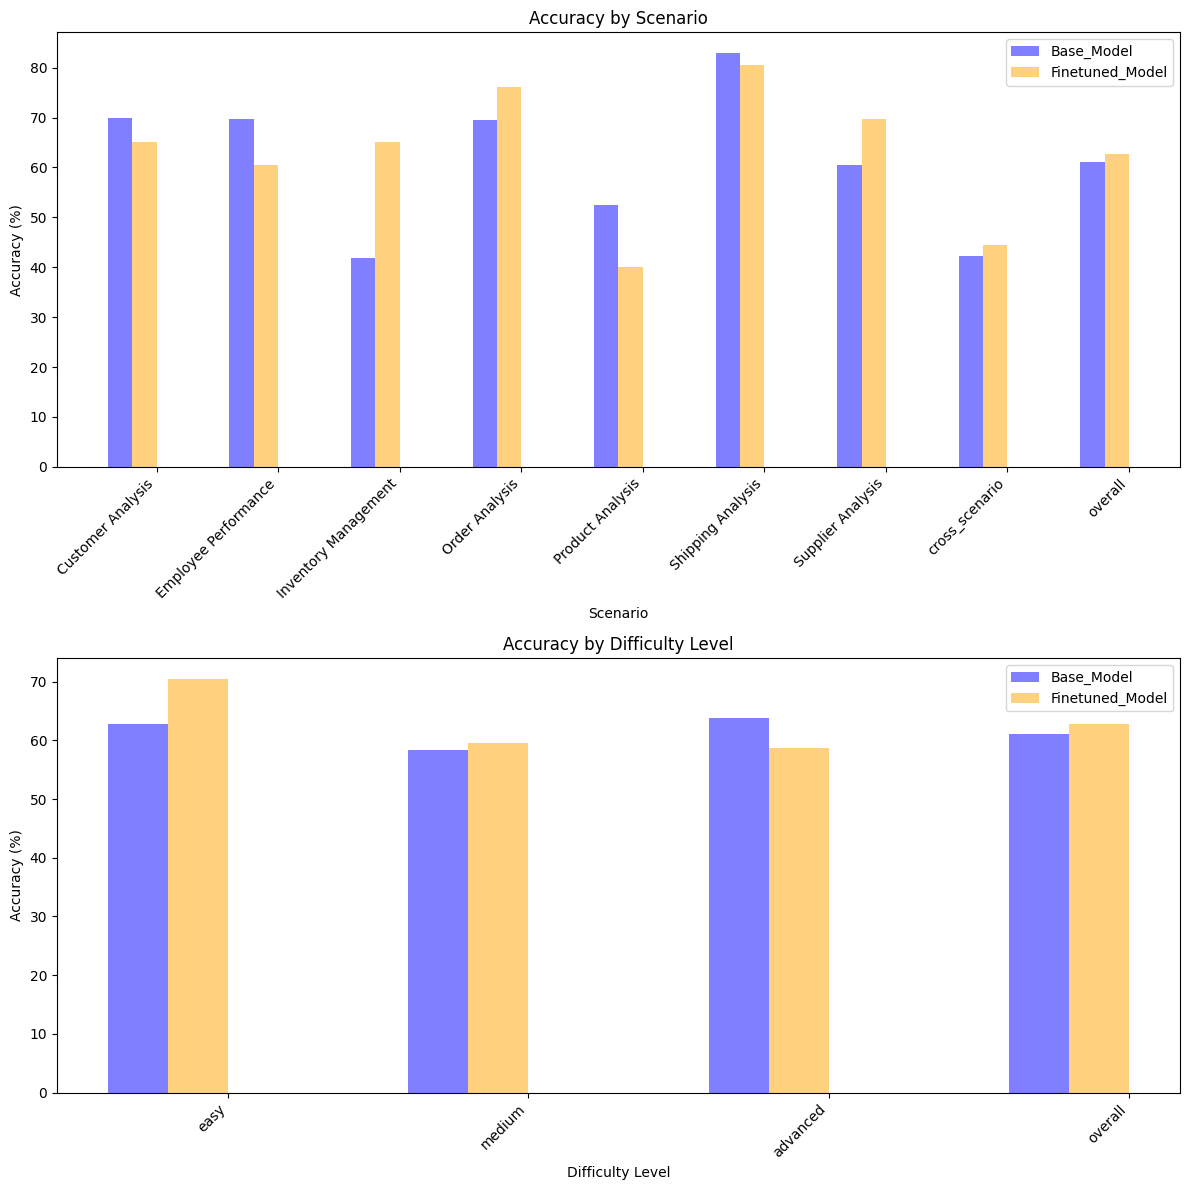

In [8]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  
import csv  
  
# Load environment variables  
env_path = Path('../../') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/processed_test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../../sql_gen/data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate Python code using the base OpenAI model with augmented prompt  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def generate_python_code_base_model(business_analytic_request, schema):  
    user_message = f"""  
### Task Description:

Given the following business analytic request, generate syntactically correct Python code that works within the specified Python environment and meets the requirements of the business request.

### Business Analytic Request:

{business_analytic_request}

### Database Schema and Business Metrics Definitions:

{schema}

### Python Environment Constraint:

You are provided with the following utility Python functions to use inside your code:

- execute_sql_query(sql_query: str) - a function to execute an SQL query against the SQL database to retrieve the data you need. This function returns a pandas DataFrame that you can use to perform any data analysis and visualization.
- show_to_user(data) - a utility function to display the data analysis and visualization result from this environment to the user. This function can take a pandas DataFrame or a Plotly figure as input. For example, to visualize a Plotly figure, the code can be:

fig = px.line(some_df)  
show_to_user(fig)  
Only use Plotly for graph visualization.

### Output Format:

Write the generated Python code without any added comment or explanation.


    """  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are an excellent data analyst with strong python and SQL background"},  
            {"role": "user", "content": user_message},  
        ],  
    )  
    return response.choices[0].message.content  
  
# Function to generate Python code using the finetuned OpenAI model  
def generate_python_code_finetuned_model(question):  

    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_PYTHON"),  
        messages=[  
            {"role": "system", "content": "You are an expert data analyst with strong Python programming and data analysis background.You are working on your company's MDDX datawarehouse. Write Python code that can provide answer for user request"},  
            {"role": "user", "content": '## Request: '+question},  
        ],  
    )  
    return response.choices[0].message.content  
  
# Function to evaluate Python code  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_python_code(business_analytic_request, generated_python_code, ground_truth_code):  
    user_message = f"""  
### Task Description:

Evaluate the correctness of the provided Python code based on a specified business analytics request and a reference implementation. The code is considered correct if it answers the question and adheres to the same logic as the reference implementation, even if the code is not identical.

Business Analytics Request:

{business_analytic_request}

### Reference Python Code Implementation:

{ground_truth_code}

### Input Python Code to Evaluate:

{generated_python_code}

### Output Format:
Respond in JSON format with 2 elements as below

{{  
  "result": "just a single word yes or no. yes means correct, no means not correct",  
  "explanation": "explanation for the decision"  
}}  
    """  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are an expert data analyst with strong Python programming and data analysis background"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "Base_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Finetuned_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate Python code and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    business_analytic_request = item["input"]  
    ground_truth_code = item["output"]  # Assuming ground_truth_code is present in the test data  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    # Generate Python code using the base model with augmented prompt  
    generated_code_base_model = generate_python_code_base_model(business_analytic_request, schema)  
  
    # Generate Python code using the finetuned model with its training prompts  
    generated_code_finetuned_model = generate_python_code_finetuned_model(business_analytic_request)  
  
    # Evaluate the generated codes  
    evaluation_result_base_model, explanation_base = evaluate_python_code(business_analytic_request, generated_code_base_model, ground_truth_code)  
    evaluation_result_finetuned_model, explanation_finetuned = evaluate_python_code(business_analytic_request, generated_code_finetuned_model, ground_truth_code)  
  
    # Update results for base model  
    results_by_setup["Base_Model"][scenario]["total"] += 1  
    results_by_setup["Base_Model"][difficulty]["total"] += 1  
    if evaluation_result_base_model == 'yes':  
        results_by_setup["Base_Model"][scenario]["correct"] += 1  
        results_by_setup["Base_Model"][difficulty]["correct"] += 1  
  
    # Update results for finetuned model  
    results_by_setup["Finetuned_Model"][scenario]["total"] += 1  
    results_by_setup["Finetuned_Model"][difficulty]["total"] += 1  
    if evaluation_result_finetuned_model == 'yes':  
        results_by_setup["Finetuned_Model"][scenario]["correct"] += 1  
        results_by_setup["Finetuned_Model"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        business_analytic_request,  
        ground_truth_code,  
        generated_code_base_model,  
        explanation_base,  
        generated_code_finetuned_model,  
        explanation_finetuned,  
        "Base" if evaluation_result_base_model == 'yes' and evaluation_result_finetuned_model == 'no' else "Finetuned" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'no' else "both" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_pythonft_0908.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "Business Analytic Request",  
        "Ground Truth Code",  
        "Generated Code by Base Model",  
        "Base Model Explanation",  
        "Generated Code by Finetuned Model",  
        "Finetuned Model Explanation",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["Base_Model"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    scenario_accuracies = [  
        (results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names  
    ] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0  
    ]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    difficulty_accuracies = [  
        (results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels  
    ] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0  
    ]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  


Accuracy by Scenario:

Accuracy for Base_Model:
  Scenario: Order Analysis, Accuracy: 82.61%
  Scenario: Product Analysis, Accuracy: 47.50%
  Scenario: Inventory Management, Accuracy: 55.81%
  Scenario: cross_scenario, Accuracy: 48.89%
  Scenario: Employee Performance, Accuracy: 74.42%
  Scenario: Shipping Analysis, Accuracy: 80.49%
  Scenario: Supplier Analysis, Accuracy: 58.14%
  Scenario: Customer Analysis, Accuracy: 75.00%
  Overall Accuracy: 65.40%

Accuracy for Finetuned_Model:
  Scenario: Order Analysis, Accuracy: 56.52%
  Scenario: Product Analysis, Accuracy: 52.50%
  Scenario: Inventory Management, Accuracy: 67.44%
  Scenario: cross_scenario, Accuracy: 64.44%
  Scenario: Employee Performance, Accuracy: 34.88%
  Scenario: Shipping Analysis, Accuracy: 75.61%
  Scenario: Supplier Analysis, Accuracy: 55.81%
  Scenario: Customer Analysis, Accuracy: 70.00%
  Overall Accuracy: 59.53%
...


### Python FT with no context vs. Base GPT-4o-mini with context

In [ ]:
import os  
import json  
import matplotlib.pyplot as plt  
from pathlib import Path  
from dotenv import load_dotenv  
from openai import AzureOpenAI  
from collections import defaultdict  
from tenacity import retry, wait_random_exponential, stop_after_attempt, stop_after_delay  
import csv  
  
# Load environment variables  
env_path = Path('../../') / 'secrets.env'  
load_dotenv(dotenv_path=env_path)  
  
openaikey = os.getenv("AZURE_OPENAI_API_KEY")  
openaiservice = os.getenv("AZURE_OPENAI_ENDPOINT")  
openaikey_base = os.getenv("AZURE_OPENAI_API_KEY_BASE")  
openaiservice_base = os.getenv("AZURE_OPENAI_ENDPOINT_BASE")  
  
# Initialize OpenAI client  
client = AzureOpenAI(api_key=openaikey, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice)  
client_base = AzureOpenAI(api_key=openaikey_base, api_version=os.getenv("AZURE_OPENAI_API_VERSION"), azure_endpoint=openaiservice_base)  
  
# Load the test dataset  
with open("../data/processed_test_data_v3.json", "r") as file:  
    test_data = json.load(file)  
  
# Load the schema information  
with open("../../sql_gen/data/analytic_graph.json", "r") as file:  
    ontology = json.load(file)  
  
split_scenarios = {}  
for scenario in ontology["business_scenarios"]:  
    scenario_name = scenario["scenario"]  
    split_scenarios[scenario_name] = {  
        "date_format": ontology["date_format"],  
        "scenario": scenario,  
        "tables": {},  
        "metrics": []  
    }  
    for mapping in ontology["scenario_metric_mapping"]:  
        if mapping["scenario"] == scenario_name:  
            for metric_name in mapping["metrics"]:  
                for metric in ontology["business_metrics"]:  
                    if metric["name"] == metric_name:  
                        split_scenarios[scenario_name]["metrics"].append(metric)  
                        for table in metric["tables"]:  
                            if table not in split_scenarios[scenario_name]["tables"]:  
                                split_scenarios[scenario_name]["tables"][table] = ontology["tables"][table]  
  
split_scenarios["cross_scenario"] = json.dumps(ontology, indent=4)  
  
# Function to generate Python code using the base OpenAI model with augmented prompt  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def generate_python_code_base_model(business_analytic_request, schema):  
    user_message = f"""  
### Task Description:

Given the following business analytic request, generate syntactically correct Python code that works within the specified Python environment and meets the requirements of the business request.

### Business Analytic Request:

{business_analytic_request}

### Database Schema and Business Metrics Definitions:

{schema}

### Python Environment Constraint:

You are provided with the following utility Python functions to use inside your code:

- execute_sql_query(sql_query: str) - a function to execute an SQL query against the SQL database to retrieve the data you need. This function returns a pandas DataFrame that you can use to perform any data analysis and visualization.
- show_to_user(data) - a utility function to display the data analysis and visualization result from this environment to the user. This function can take a pandas DataFrame or a Plotly figure as input. For example, to visualize a Plotly figure, the code can be:

fig = px.line(some_df)  
show_to_user(fig)  
Only use Plotly for graph visualization.

### Output Format:

Write the generated Python code without any added comment or explanation.


    """  
    response = client_base.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_BASE_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are an excellent data analyst with strong python and SQL background"},  
            {"role": "user", "content": user_message},  
        ],  
    )  
    return response.choices[0].message.content  
  
# Function to generate Python code using the finetuned OpenAI model  
def generate_python_code_finetuned_model(question):  

    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_FT_DEPLOYMENT_PYTHON"),  
        messages=[  
            {"role": "system", "content": "You are an expert data analyst with strong Python programming and data analysis background.You are working on your company's MDDX datawarehouse. Write Python code that can provide answer for user request"},  
            {"role": "user", "content": '## Request: '+question},  
        ],  
    )  
    return response.choices[0].message.content  
  
# Function to evaluate Python code  
@retry(wait=wait_random_exponential(multiplier=1, max=60), stop=(stop_after_attempt(10) | stop_after_delay(300)))  
def evaluate_python_code(business_analytic_request, generated_python_code, ground_truth_code):  
    user_message = f"""  
### Task Description:

Evaluate the correctness of the provided Python code based on a specified business analytics request and a reference implementation. The code is considered correct if it answers the question and adheres to the same logic as the reference implementation, even if the code is not identical.

Business Analytics Request:

{business_analytic_request}

### Reference Python Code Implementation:

{ground_truth_code}

### Input Python Code to Evaluate:

{generated_python_code}

### Output Format:
Respond in JSON format with 2 elements as below

{{  
  "result": "just a single word yes or no. yes means correct, no means not correct",  
  "explanation": "explanation for the decision"  
}}  
    """  
    response = client.chat.completions.create(  
        model=os.environ.get("AZURE_OPENAI_CHAT_DEPLOYMENT"),  
        messages=[  
            {"role": "system", "content": "You are an expert data analyst with strong Python programming and data analysis background"},  
            {"role": "user", "content": user_message},  
        ],  
        response_format={"type": "json_object"},  
    )  
    response_message = json.loads(response.choices[0].message.content)  
    return response_message["result"].strip().lower(), response_message["explanation"]  
  
# Initialize dictionaries to store evaluation results  
results_by_setup = {  
    "Base_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
    "Finetuned_Model": defaultdict(lambda: {"correct": 0, "total": 0}),  
}  
  
# List to store CSV rows  
csv_rows = []  
  
# Generate Python code and evaluate them  
for item in test_data:  
    scenario = item["scenario"]  
    difficulty = item["difficulty"]  
    business_analytic_request = item["input"]  
    ground_truth_code = item["output"]  # Assuming ground_truth_code is present in the test data  
  
    # Merge "hard" with "advanced"  
    if difficulty == "hard":  
        difficulty = "advanced"  
  
    schema = json.dumps(split_scenarios[item["scenario"]], indent=4) if item["scenario"] != "cross_scenario" else split_scenarios["cross_scenario"]  
  
    # Generate Python code using the base model with augmented prompt  
    generated_code_base_model = generate_python_code_base_model(business_analytic_request, schema)  
  
    # Generate Python code using the finetuned model with its training prompts  
    generated_code_finetuned_model = generate_python_code_finetuned_model(business_analytic_request)  
  
    # Evaluate the generated codes  
    evaluation_result_base_model, explanation_base = evaluate_python_code(business_analytic_request, generated_code_base_model, ground_truth_code)  
    evaluation_result_finetuned_model, explanation_finetuned = evaluate_python_code(business_analytic_request, generated_code_finetuned_model, ground_truth_code)  
  
    # Update results for base model  
    results_by_setup["Base_Model"][scenario]["total"] += 1  
    results_by_setup["Base_Model"][difficulty]["total"] += 1  
    if evaluation_result_base_model == 'yes':  
        results_by_setup["Base_Model"][scenario]["correct"] += 1  
        results_by_setup["Base_Model"][difficulty]["correct"] += 1  
  
    # Update results for finetuned model  
    results_by_setup["Finetuned_Model"][scenario]["total"] += 1  
    results_by_setup["Finetuned_Model"][difficulty]["total"] += 1  
    if evaluation_result_finetuned_model == 'yes':  
        results_by_setup["Finetuned_Model"][scenario]["correct"] += 1  
        results_by_setup["Finetuned_Model"][difficulty]["correct"] += 1  
  
    # Collect data for CSV  
    csv_rows.append([  
        business_analytic_request,  
        ground_truth_code,  
        generated_code_base_model,  
        explanation_base,  
        generated_code_finetuned_model,  
        explanation_finetuned,  
        "Base" if evaluation_result_base_model == 'yes' and evaluation_result_finetuned_model == 'no' else "Finetuned" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'no' else "both" if evaluation_result_finetuned_model == 'yes' and evaluation_result_base_model == 'yes' else "None"  
    ])  
  
# Write CSV  
with open("evaluation_results_pythonft_0908_v5.csv", "w", newline="") as csvfile:  
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerow([  
        "Business Analytic Request",  
        "Ground Truth Code",  
        "Generated Code by Base Model",  
        "Base Model Explanation",  
        "Generated Code by Finetuned Model",  
        "Finetuned Model Explanation",  
        "Model that got it right"  
    ])  
    csvwriter.writerows(csv_rows)  
  
# Calculate and print accuracy by scenario for each setup  
print("\nAccuracy by Scenario:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for scenario, counts in setup_results.items():  
        if scenario in ["easy", "medium", "advanced"]:  
            continue  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Scenario: {scenario}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Calculate and print accuracy by difficulty for each setup  
print("\nAccuracy by Difficulty Level:")  
for setup_name, setup_results in results_by_setup.items():  
    print(f"\nAccuracy for {setup_name}:")  
    overall_correct = 0  
    overall_total = 0  
    for difficulty in ["easy", "medium", "advanced"]:  
        counts = setup_results[difficulty]  
        accuracy = (counts["correct"] / counts["total"]) * 100 if counts["total"] > 0 else 0  
        overall_correct += counts["correct"]  
        overall_total += counts["total"]  
        print(f"  Difficulty: {difficulty}, Accuracy: {accuracy:.2f}%")  
    overall_accuracy = (overall_correct / overall_total) * 100 if overall_total > 0 else 0  
    print(f"  Overall Accuracy: {overall_accuracy:.2f}%")  
  
# Visualize accuracy by scenario for each setup  
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))  
  
# Prepare data for plotting  
scenario_names = sorted(set(s for s in results_by_setup["Base_Model"] if s not in ["easy", "medium", "advanced"]))  
difficulty_levels = ["easy", "medium", "advanced"]  
all_scenarios = scenario_names + ["overall"]  
all_difficulties = difficulty_levels + ["overall"]  
  
# Calculate overall accuracies  
for setup_name, setup_results in results_by_setup.items():  
    overall_correct = sum(setup_results[s]["correct"] for s in scenario_names)  
    overall_total = sum(setup_results[s]["total"] for s in scenario_names)  
    setup_results["overall_scenario"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
    overall_correct = sum(setup_results[d]["correct"] for d in difficulty_levels)  
    overall_total = sum(setup_results[d]["total"] for d in difficulty_levels)  
    setup_results["overall_difficulty"] = {  
        "correct": overall_correct,  
        "total": overall_total  
    }  
  
# Plot accuracy by scenario  
width = 0.2  
x_scenario = range(len(all_scenarios))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    scenario_accuracies = [  
        (results_by_setup[setup_name][s]["correct"] / results_by_setup[setup_name][s]["total"]) * 100 if results_by_setup[setup_name][s]["total"] > 0 else 0 for s in scenario_names  
    ] + [  
        (results_by_setup[setup_name]["overall_scenario"]["correct"] / results_by_setup[setup_name]["overall_scenario"]["total"]) * 100 if results_by_setup[setup_name]["overall_scenario"]["total"] > 0 else 0  
    ]  
    axes[0].bar([p + idx * width for p in x_scenario], scenario_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[0].set_title('Accuracy by Scenario')  
axes[0].set_xlabel('Scenario')  
axes[0].set_ylabel('Accuracy (%)')  
axes[0].set_xticks([p + 1.5 * width for p in x_scenario])  
axes[0].set_xticklabels(all_scenarios, rotation=45, ha='right')  
axes[0].legend()  
  
# Plot accuracy by difficulty  
x_difficulty = range(len(all_difficulties))  
for idx, (setup_name, color) in enumerate(zip(results_by_setup.keys(), ['blue', 'orange'])):  
    difficulty_accuracies = [  
        (results_by_setup[setup_name][d]["correct"] / results_by_setup[setup_name][d]["total"]) * 100 if results_by_setup[setup_name][d]["total"] > 0 else 0 for d in difficulty_levels  
    ] + [  
        (results_by_setup[setup_name]["overall_difficulty"]["correct"] / results_by_setup[setup_name]["overall_difficulty"]["total"]) * 100 if results_by_setup[setup_name]["overall_difficulty"]["total"] > 0 else 0  
    ]  
    axes[1].bar([p + idx * width for p in x_difficulty], difficulty_accuracies, width=width, color=color, alpha=0.5, label=setup_name)  
    axes[1].set_title('Accuracy by Difficulty Level')  
axes[1].set_xlabel('Difficulty Level')  
axes[1].set_ylabel('Accuracy (%)')  
axes[1].set_xticks([p + 1.5 * width for p in x_difficulty])  
axes[1].set_xticklabels(all_difficulties, rotation=45, ha='right')  
axes[1].legend()  
  
plt.tight_layout()  
plt.show()  
